In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from __future__ import division

import numpy as np
import glob, time, pickle, os, json, sys
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.linalg as sl
from scipy.stats import chi2

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Do not have mpi4py package.


In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
# top_path_idx = splt_path.index("akaiser")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

e_e_path = top_dir + "/enterprise_extensions/"
noise_path = top_dir + "/pta_sim/pta_sim"
sys.path.insert(0, noise_path)
sys.path.insert(0, e_e_path)
import enterprise_extensions as e_e
from enterprise_extensions import models, sampler
from enterprise_extensions.sampler import JumpProposal
from enterprise_extensions.frequentist import F_statistic
import noise

In [5]:
#Directories for MDC2
dataset = '/dataset_1b'

fstat_dir = os.getcwd()
mdc2_dir = os.path.split(fstat_dir)[0]
#Where the original data is
origdatadir = mdc2_dir + '/MDC2/mdc2/group1' + dataset
#Where the json noise file is
noisefile = mdc2_dir + '/MDC2/mdc2/group1/group1_psr_noise.json'
#Where the everything should be saved to (chains, cornerplts, histograms, etc.
savedir = fstat_dir
#The pickled pulsars
psr_obj_file = fstat_dir + '/mdc2_psr_objects.pickle'

In [6]:
#par and tim from mdc2
parfiles = sorted(glob.glob(origdatadir + '/*.par'))
timfiles = sorted(glob.glob(origdatadir + '/*.tim'))

In [7]:
#Loading par and tim files into enterprise Pulsar class
#If no pickle file, load and save pulsars
psrs_mdc2 = []
for p, t in zip(parfiles,timfiles):
    psr = Pulsar(p, t)
    psrs_mdc2.append(psr)
#Save pulsars to a pickle file
with open(psr_obj_file,'wb') as psrfile:
    pickle.dump(psrs_mdc2,psrfile)
    psrfile.close()

In [8]:
#Get true noise values for pulsars in mdc2
params_mdc2 = {}
with open(noisefile, 'r') as nf:
    params_dict_mdc2 = json.load(nf)
    nf.close()
for psr, params in params_dict_mdc2.items():
    for param_name, param_val in params.items():
        if param_name == 'efac':
            updated_param_name = psr + '_efac'
        elif param_name == 'equad':
            updated_param_name = psr + '_log10_equad'
        elif param_name == 'ecorr':
            updated_param_name = psr + '_log10_ecorr'
        elif param_name == 'rn_log10_A':
            updated_param_name = psr + '_red_noise_log10_A'
        elif param_name == 'rn_spec_ind':
            updated_param_name = psr + '_red_noise_gamma'

        params_mdc2[updated_param_name] = param_val

In [9]:
def GetTspan(psrs):
    tmin = [p.toas.min() for p in psrs]
    tmax = [p.toas.max() for p in psrs]
    Tspan = np.max(tmax) - np.min(tmin)
    return Tspan

In [10]:
##### parameters and priors for MDC2 #####
Tspan_mdc2 = GetTspan(psrs_mdc2)

# white noise parameters
efac = parameter.Constant()
log10_equad = parameter.Constant()
ecorr = parameter.Constant()

# red noise parameters
log10_A = parameter.Constant()
gamma = parameter.Constant()

'''
# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')
'''

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)

rn_mdc2 = gp_signals.FourierBasisGP(spectrum=pl, Tspan=Tspan_mdc2)

'''
# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan)
'''

# timing model
tm = gp_signals.TimingModel()

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac)
eq = white_signals.EquadNoise(log10_equad=log10_equad)

# full model is sum of components
model_mdc2 = tm + ef + eq + rn_mdc2

# intialize PTA
pta_mdc2 = signal_base.PTA([model_mdc2(psr) for psr in psrs_mdc2])

In [11]:
#Set Default PTA parameters to the ones in the noisefiles
pta_mdc2.set_default_params(params_mdc2)

INFO: enterprise.signals.signal_base: Setting J0030+0451_efac to 1.1327054973277817
INFO: enterprise.signals.signal_base: Setting J0030+0451_log10_equad to -6.734253117324852
INFO: enterprise.signals.signal_base: Setting J0030+0451_red_noise_log10_A to -14.148297681223301
INFO: enterprise.signals.signal_base: Setting J0030+0451_red_noise_gamma to 4.495492402026417
INFO: enterprise.signals.signal_base: Setting J0034-0534_efac to 1.2598373277400674
INFO: enterprise.signals.signal_base: Setting J0034-0534_log10_equad to -6.641425922580685
INFO: enterprise.signals.signal_base: Setting J0034-0534_red_noise_log10_A to -16.538151630942075
INFO: enterprise.signals.signal_base: Setting J0034-0534_red_noise_gamma to 3.34288428623134
INFO: enterprise.signals.signal_base: Setting J0218+4232_efac to 1.3501857107640765
INFO: enterprise.signals.signal_base: Setting J0218+4232_log10_equad to -6.753752501179396
INFO: enterprise.signals.signal_base: Setting J0218+4232_red_noise_log10_A to -16.7050885818

INFO: enterprise.signals.signal_base: Setting J1857+0943_red_noise_log10_A to -14.240807998662445
INFO: enterprise.signals.signal_base: Setting J1857+0943_red_noise_gamma to 4.6295408167717005
INFO: enterprise.signals.signal_base: Setting J1909-3744_efac to 1.095400467856472
INFO: enterprise.signals.signal_base: Setting J1909-3744_log10_equad to -7.213183522763408
INFO: enterprise.signals.signal_base: Setting J1909-3744_red_noise_log10_A to -17.32727924372078
INFO: enterprise.signals.signal_base: Setting J1909-3744_red_noise_gamma to 3.18721293346236
INFO: enterprise.signals.signal_base: Setting J1918-0642_efac to 1.0819378030429965
INFO: enterprise.signals.signal_base: Setting J1918-0642_log10_equad to -7.556289609789052
INFO: enterprise.signals.signal_base: Setting J1918-0642_red_noise_log10_A to -15.681503899653743
INFO: enterprise.signals.signal_base: Setting J1918-0642_red_noise_gamma to 3.161506983264447
INFO: enterprise.signals.signal_base: Setting J1939+2134_efac to 2.205813948

In [12]:
# make sure all pulsar have same reference time
def GetRefTime(psrs):
    tt=[] 
    for p in psrs:
        tt.append(np.min(p.toas))

    # find reference time
    tref = np.min(tt)
    newtoas = []
    # now scale pulsar time
    for p in psrs:
        newtoas.append((p.toas - tref))
    return newtoas

In [13]:
def GenNmat(pta,params):
    '''Makes the Nmatrix used in the fstatistic'''
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition') 
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    #Get the basis matrix
    Ts = pta.get_basis(params)
    Nmat = []
    print('Making Nmat')
    l1 = np.shape(TNTs)[0]
    i = 1
    
    for phiinv, TNT, Nvec, T in zip(phiinvs, TNTs, Nvecs, Ts):
        start = time.time()
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        Nshape = np.shape(T)[0]
        TtN = Nvec.solve(other = np.eye(Nshape),left_array = T)
        
        #Put pulsar's autoerrors in a diagonal matrix
        Ndiag = Nvec.solve(other = np.eye(Nshape),left_array = np.eye(Nshape))
    
        expval2 = sl.cho_solve(cf,TtN)
        #TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtN.T,expval2))
        end = time.time()
        print(repr(i) + ' out of ' + repr(l1) + ' Done. Time: ' + repr(end-start))
        i += 1
    return Nmat

In [14]:
#Making Nmatrix for mdc2
Nmat_mdc2 = GenNmat(pta_mdc2,params_mdc2)

Making Nmat
1 out of 33 Done. Time: 0.0037648677825927734
2 out of 33 Done. Time: 0.0018837451934814453
3 out of 33 Done. Time: 0.0014138221740722656
4 out of 33 Done. Time: 0.0017137527465820312
5 out of 33 Done. Time: 0.0014162063598632812
6 out of 33 Done. Time: 0.0017049312591552734
7 out of 33 Done. Time: 0.001405954360961914
8 out of 33 Done. Time: 0.0015971660614013672
9 out of 33 Done. Time: 0.0014219284057617188
10 out of 33 Done. Time: 0.0013921260833740234
11 out of 33 Done. Time: 0.0013740062713623047
12 out of 33 Done. Time: 0.0015628337860107422
13 out of 33 Done. Time: 0.001421213150024414
14 out of 33 Done. Time: 0.0013701915740966797
15 out of 33 Done. Time: 0.0014920234680175781
16 out of 33 Done. Time: 0.0014579296112060547
17 out of 33 Done. Time: 0.0013508796691894531
18 out of 33 Done. Time: 0.001415252685546875
19 out of 33 Done. Time: 0.0015561580657958984
20 out of 33 Done. Time: 0.0015149116516113281
21 out of 33 Done. Time: 0.0013661384582519531
22 out of 33 

In [15]:
def AndrewFpstat2(psrs,Nmat,aligned_toas,f0):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital angular frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''
    
    fpstat = 0.0
        
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(2)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((2, 2))

        # Define A vector
        A = np.zeros((2, len(aligned_toas[ii])))
        A[0,:] = f0**(-1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = f0**(-1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
        '''A = np.zeros((2, len(p.toas)))
        A[0,:] = f0**(-1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[1,:] = f0**(-1./3.) * np.cos(2*np.pi*f0*p.toas)'''
    
        # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
        """N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) """
        N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))])
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
    return fpstat

In [59]:
class AndrewFpstat(object):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital angular frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''
    def __init__(self, psrs, params=None,
                 psrTerm=True, bayesephem=True, wideband=False, pta=None):
        
        if pta is None:

            # initialize standard model with fixed white noise and powerlaw red noise
            print('Initializing the model...')
            self.pta = models.model_cw(psrs, noisedict=params, rn_psd='powerlaw',
                                       ecc=False, psrTerm=psrTerm,
                                       bayesephem=bayesephem, wideband=wideband)
        else:
            self.pta = pta

        self.psrs = psrs
        self.params = params
        
    def innerProduct_rr(self,x, y, Nvec, Tmat, Sigma, xNT=None, TNy=None):
        """
        Compute inner product using rank-reduced
        approximations for red noise/jitter
        Compute: x^T N^{-1} y - x^T N^{-1} T \Sigma^{-1} T^T N^{-1} y

        :param x: vector timeseries 1
        :param y: vector timeseries 2
        :param Nvec: diagonal of white noise matrix
        :param Tmat: Modified design matrix including red noise/jitter
        :param Sigma: Sigma matrix (\varphi^{-1} + T^T N^{-1} T)
        :param TNx: T^T N^{-1} x precomputed
        :param TNy: T^T N^{-1} y precomputed
        :return: inner product (x|y)
        """
        # white noise term
        xNy = Nvec.solve(y,left_array=x)

        if xNT == None and TNy == None:
            xNT = Nvec.solve(Tmat,left_array=x)
            TNy = Nvec.solve(y,left_array=Tmat)

        cf = sl.cho_factor(Sigma)
        SigmaTNy = sl.cho_solve(cf, TNy)

        ret = xNy - np.dot(xNT, SigmaTNy)

        return ret
    
    def compute_Fp(self, fgw):
        """
        Computes the Fp-statistic.
        :param fgw: GW frequency
        :returns:
        fstat: value of the Fp-statistic at the given frequency
        """
        
        phiinvs = self.pta.get_phiinv(self.params, logdet=False)
        TNTs = self.pta.get_TNT(self.params)
        Ts = self.pta.get_basis()
        Nvecs = self.pta.get_ndiag()
        
        N = np.zeros(2)
        M = np.zeros((2,2))
        fstat = 0
        
        for psr, TNT, phiinv, T, Nvec in zip(self.psrs,TNTs, phiinvs, Ts, Nvecs):
            Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
            
            ntoa = len(psr.toas)
            
            A = np.zeros((2, ntoa))
            A[0, :] = 1 / fgw ** (1 / 3) * np.sin(2 * np.pi * fgw * psr.toas)
            A[1, :] = 1 / fgw ** (1 / 3) * np.cos(2 * np.pi * fgw * psr.toas)
            
            ip1 = self.innerProduct_rr(psr.residuals, A[0, :], Nvec, T, Sigma)
            ip2 = self.innerProduct_rr(psr.residuals, A[1, :], Nvec, T, Sigma)
            N = np.array([ip1, ip2])
                                  
            # define M matrix M_ij=(A_i|A_j)
            for jj in range(2):
                for kk in range(2):
                    M[jj, kk] = self.innerProduct_rr(A[jj, :], A[kk, :], Nvec, T, Sigma)

            # take inverse of M
            Minv = np.linalg.pinv(M)
            fstat += 0.5 * np.dot(N, np.dot(Minv, N))
    
        return fstat

In [60]:
fstat_e_e = F_statistic.FpStat(psrs_mdc2,pta=pta_mdc2,params=params_mdc2)
fstat_andiii = AndrewFpstat(psrs_mdc2,pta=pta_mdc2,params=params_mdc2)

In [61]:
fstat_andiii.compute_Fp(1e-9)

38.71540953740893

In [62]:
nfreqs = 100
#Use delf to shift frequencies by less than a bin to get more samples
delf = 2/(3*Tspan_mdc2)
startfreq_mdc2 = 1/Tspan_mdc2 + delf
endfreq_mdc2 = 3.3e-7
#logfreqs = np.logspace(np.log10(startfreq),np.log10(endfreq),nfreqs) Does not sample independent frequencies
linfreqs_mdc2 = np.arange(startfreq_mdc2,endfreq_mdc2,1/Tspan_mdc2)

newtoas_mdc2 = GetRefTime(psrs_mdc2)

i = 1
fstat_array_mdc2 = []
fstat_e_e_array_mdc2 = []
fstat_andiii_array_mdc2 = []
start = time.time()
for gwfreq in linfreqs_mdc2:
    fstat_array_mdc2.append(AndrewFpstat2(psrs_mdc2,Nmat_mdc2,newtoas_mdc2,gwfreq))
    fstat_e_e_array_mdc2.append(fstat_e_e.compute_Fp(gwfreq))
    fstat_andiii_array_mdc2.append(fstat_andiii.compute_Fp(gwfreq))
    if i % 10 == 0:
        end = time.time()
        print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    i += 1

10 Done.  Time Elapsed: 1.2066059112548828
20 Done.  Time Elapsed: 2.349241018295288
30 Done.  Time Elapsed: 3.4825990200042725
40 Done.  Time Elapsed: 4.69718599319458
50 Done.  Time Elapsed: 5.889122009277344
60 Done.  Time Elapsed: 7.083703994750977
70 Done.  Time Elapsed: 8.282214164733887
80 Done.  Time Elapsed: 9.435985088348389
90 Done.  Time Elapsed: 10.607587099075317
100 Done.  Time Elapsed: 11.872414827346802
110 Done.  Time Elapsed: 13.07908296585083
120 Done.  Time Elapsed: 14.28430986404419
130 Done.  Time Elapsed: 15.417187929153442
140 Done.  Time Elapsed: 16.60217308998108
150 Done.  Time Elapsed: 17.839138984680176


# Fp Statistic Histograms and Frequency Plots

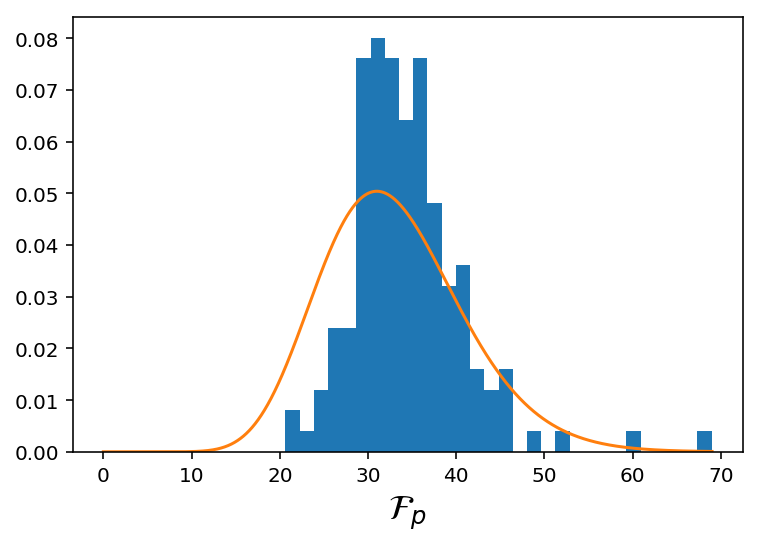

In [66]:
#Test Histograms
#Making chi squared values
dof_mdc2 = len(psrs_mdc2)
N_x_mdc2 = 10000
chi_x_mdc2 = np.linspace(0,int(max(fstat_array_mdc2))+1,N_x_mdc2)

nbins = 30
#plt.hist(fstat_array,bins = nbins,density = True)
#plt.hist(2*fstat_array_mdc2,bins = nbins,density = True)
#plt.hist(2*fstat_e_e_array_mdc2,bins = nbins,density = True)
plt.hist(2*fstat_andiii_array_mdc2,bins = nbins,density = True)
plt.plot(chi_x_mdc2,chi2.pdf(chi_x_mdc2,dof_mdc2))
#plt.hist(fstat_array_test,bins = nbins,density = True)
plt.xlabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
plt.show()

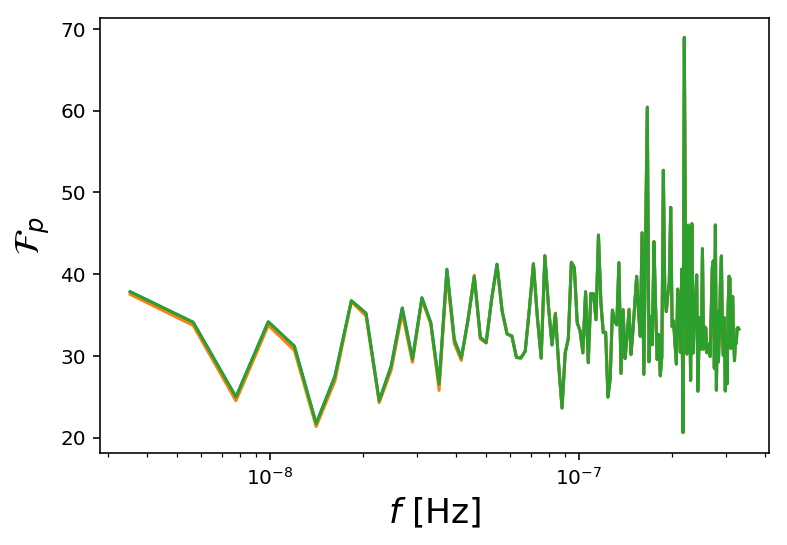

In [67]:
#Test Frequency plots
plt.plot(linfreqs_mdc2,fstat_array_mdc2)
plt.plot(linfreqs_mdc2,fstat_e_e_array_mdc2)
plt.plot(linfreqs_mdc2,fstat_andiii_array_mdc2)

plt.xscale('log')
plt.ylabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
plt.xlabel(r'$f$ [Hz]',fontsize = 'xx-large')
plt.show()

# Fe Statistic

In [20]:
def AndrewFestat2(psrs,Nmat,aligned_toas,f0,gwphi,gwtheta):
    '''Takes in the pulsars that make up the pta, the Nmatrix from GetNmat 
    (Should make this a function in ptas to use self instead of pta?),
    the frequency of the gravitational wave, phi (GW azimuthal angle in radians), 
    and theta (GW polar angle in radians).
    Returns the Fe statistic
    '''
    festat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(4)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((4,4))

        fplus, fcross, cosMu = utils.create_gw_antenna_pattern(p.pos, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(aligned_toas[ii])))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])

        N += np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[1,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[2,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[3,:], np.dot(Nmat[ii],p.residuals))])
    
        # define M matrix M_ij=(A_i|A_j)
        M += np.dot(A, np.dot(Nmat[ii], A.T))
        
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        festat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return festat

In [21]:
#Pick gw sky location for tests
gwtheta = 30/180*np.pi
gwphi = 10/180*np.pi

In [22]:
i = 1
festat_array_mdc2 = []
start = time.time()
for gwfreq in linfreqs_mdc2:
    festat_array_mdc2.append(AndrewFestat2(psrs_mdc2,Nmat_mdc2,newtoas_mdc2,gwfreq,gwtheta,gwphi))
    if i % 10 == 0:
        end = time.time()
        print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    i += 1

10 Done.  Time Elapsed: 0.14721202850341797
20 Done.  Time Elapsed: 0.2859220504760742
30 Done.  Time Elapsed: 0.43056797981262207
40 Done.  Time Elapsed: 0.5684139728546143
50 Done.  Time Elapsed: 0.713529109954834
60 Done.  Time Elapsed: 0.8495528697967529
70 Done.  Time Elapsed: 0.9956481456756592
80 Done.  Time Elapsed: 1.1413021087646484
90 Done.  Time Elapsed: 1.292037010192871
100 Done.  Time Elapsed: 1.4285471439361572
110 Done.  Time Elapsed: 1.5730090141296387
120 Done.  Time Elapsed: 1.7106900215148926
130 Done.  Time Elapsed: 1.859158992767334
140 Done.  Time Elapsed: 2.000195026397705
150 Done.  Time Elapsed: 2.1471869945526123


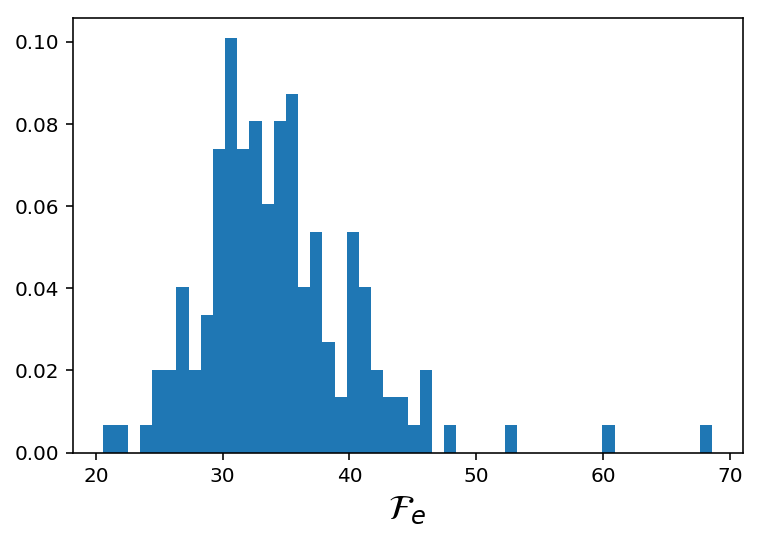

In [23]:
nbins = 50
plt.hist(festat_array_mdc2,bins = nbins,density = True)
plt.xlabel(r'$\mathcal{F}_{e}$',fontsize = 'xx-large')
plt.show()